In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
suchintikasarkar_sentiment_analysis_for_mental_health_path = kagglehub.dataset_download('suchintikasarkar/sentiment-analysis-for-mental-health')

print('Data source import complete.')


Data source import complete.


# Import Toolkits

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
plt.style.use("ggplot")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertForSequenceClassification , Trainer , TrainingArguments
import torch
from torch.utils.data import DataLoader
from datasets import Dataset

In [11]:
#download stopwords
import nltk
nltk.download("stopwords")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
df = pd.read_csv("/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv")
df.sample(10)

,Unnamed: 0,statement,status
49380,49380,New eBook: Stress Management Get the inside s...,Stress
50904,50904,How do you make therapy work? I don’t know wha...,Personality disorder
10422,10422,I just started a job in customer service. Work...,Suicidal
45307,45307,whykay it s lashing down here,Normal
42190,42190,just finished a delicious breakfast my last in...,Normal
13935,13935,"Good morning, day or evening to whoever is rea...",Depression
44972,44972,edbehrens thanks for all the good luck ala i w...,Normal
28738,28738,I am constantly freaking out and unable to see...,Stress
1878,1878,"solo booth, it's better if you all go far away...",Normal
34289,34289,My health anxiety caused me to get a CT scan a...,Anxiety


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


it seems there are nan values in column statement as there`s unneeded column "Unnamed" lets drop them

In [6]:
df.dropna(inplace= True)
df.drop(columns= ['Unnamed: 0'],axis= 1 , inplace= True)
print(df.shape)
df.head(10)

(52681, 2)


,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
5,"every break, you must be nervous, like somethi...",Anxiety
6,"I feel scared, anxious, what can I do? And may...",Anxiety
7,Have you ever felt nervous but didn't know why?,Anxiety
8,"I haven't slept well for 2 days, it's like I'm...",Anxiety
9,"I'm really worried, I want to cry.",Anxiety


In [7]:
df = df.sample(n = 6000 , random_state = 42).reset_index(drop = True)
print(df.shape)
df.head(10)

(6000, 2)


,statement,status
0,I'm lazy to complain about it ba ihh,Normal
1,i think the wifi on my iphone is broken it wil...,Normal
2,Good tracking apps? I've been trying to find a...,Bipolar
3,I have recently looked into reddit and found t...,Depression
4,that's your favorite thing to do?,Normal
5,I have enough goodies to play santa claus but ...,Suicidal
6,want to sleep but soon the call to prayer for ...,Normal
7,you use them to wipe the handle of the shoppin...,Normal
8,Is it good to only focus on 1 goal? What I mea...,Stress
9,"Hi guys, I am looking for podcasts to listen t...",Depression


# Data Pre-processing

In [8]:
#let`s define porter stemmer object
port_stem = PorterStemmer()

In [9]:
def clean_statement(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]" , " " , text)
    tokens = word_tokenize(text)
    words = [port_stem.stem(word) for word in tokens if word not in stopwords.words("english")]
    statement = " ".join(words)

    return statement

In [12]:
df['statement'] = df['statement'].apply(clean_statement)

In [13]:
df.head(10)

,statement,status
0,lazi complain ba ihh,Normal
1,think wifi iphon broken quot connect quot actu...,Normal
2,good track app tri find app track overal mood ...,Bipolar
3,recent look reddit found place actual quit hea...,Depression
4,favorit thing,Normal
5,enough goodi play santa clau reindeer came way...,Suicidal
6,want sleep soon call prayer midday heavi sleepi,Normal
7,use wipe handl shop cart,Normal
8,good focu goal mean exampl goal find good job ...,Stress
9,hi guy look podcast listen tall depress anxiet...,Depression


In [14]:
df['status'].value_counts(normalize= True)

,proportion
status,
Normal,0.315667
Depression,0.288333
Suicidal,0.203167
Anxiety,0.071500
Stress,0.050667
Bipolar,0.048833
Personality disorder,0.021833


In [15]:
import plotly.express as px
mask = df['status'].value_counts(normalize= True).to_frame().reset_index()
mask

,status,proportion
0,Normal,0.315667
1,Depression,0.288333
2,Suicidal,0.203167
3,Anxiety,0.071500
4,Stress,0.050667
5,Bipolar,0.048833
6,Personality disorder,0.021833


In [17]:
fig = px.bar(data_frame= mask , x = "status" , y = "proportion" , color = "proportion")
fig.update_layout(title = "classes Distrbution")
fig.show();

In [ ]:
!pip install imblearn

In [19]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 42)
X = df.drop("status", axis=1)
y= df['status']

X_resampled , y_resampled = ros.fit_resample(X , y)

In [21]:
df = pd.concat([X_resampled, y_resampled], axis = 1)
df

,statement,status
0,lazi complain ba ihh,Normal
1,think wifi iphon broken quot connect quot actu...,Normal
2,good track app tri find app track overal mood ...,Bipolar
3,recent look reddit found place actual quit hea...,Depression
4,favorit thing,Normal
...,...,...
13253,afford therapist social anxieti depress adhd a...,Suicidal
13254,would like die simpl would realli like suffer ...,Suicidal
13255,death day time set affair might even get bedro...,Suicidal
13256,hard see other live life would kill know wonde...,Suicidal


In [22]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['status'])
df

,statement,status,label
0,lazi complain ba ihh,Normal,3
1,think wifi iphon broken quot connect quot actu...,Normal,3
2,good track app tri find app track overal mood ...,Bipolar,1
3,recent look reddit found place actual quit hea...,Depression,2
4,favorit thing,Normal,3
...,...,...,...
13253,afford therapist social anxieti depress adhd a...,Suicidal,6
13254,would like die simpl would realli like suffer ...,Suicidal,6
13255,death day time set affair might even get bedro...,Suicidal,6
13256,hard see other live life would kill know wonde...,Suicidal,6


# Data Split

In [23]:
X_train , X_test , y_train , y_test = train_test_split(df['statement'] , df['label'] , test_size= 0.2 , random_state= 42)

# Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True , max_length = 200)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length = 200)

train_encodings

In [25]:
#convert to dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'],'attention_mask': train_encodings['attention_mask'],'labels': y_train.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'],'attention_mask': test_encodings['attention_mask'],'labels': y_test.tolist()})

In [ ]:
train_dataset[0]

# FineTuning

In [27]:
len(label_encoder.classes_)

7

In [35]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased' , num_labels= len(label_encoder.classes_))
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,2.025600
20,1.986600
30,1.994800
40,1.970200
50,1.934300
60,1.912100
70,1.871600
80,1.875600
90,1.848200
100,1.817100


Step,Training Loss
10,2.025600
20,1.986600
30,1.994800
40,1.970200
50,1.934300
60,1.912100
70,1.871600
80,1.875600
90,1.848200
100,1.817100


TrainOutput(global_step=3315, training_loss=0.39900046031511927, metrics={'train_runtime': 1972.7824, 'train_samples_per_second': 26.881, 'train_steps_per_second': 1.68, 'total_flos': 5450549081100000.0, 'train_loss': 0.39900046031511927, 'epoch': 5.0})

# Evaluation

                      precision    recall  f1-score   support

             Anxiety       0.97      0.99      0.98       342
             Bipolar       0.98      1.00      0.99       397
          Depression       0.76      0.75      0.75       369
              Normal       0.93      0.89      0.91       401
Personality disorder       0.99      1.00      1.00       386
              Stress       0.94      1.00      0.97       361
            Suicidal       0.82      0.78      0.80       396

            accuracy                           0.92      2652
           macro avg       0.91      0.92      0.91      2652
        weighted avg       0.91      0.92      0.91      2652



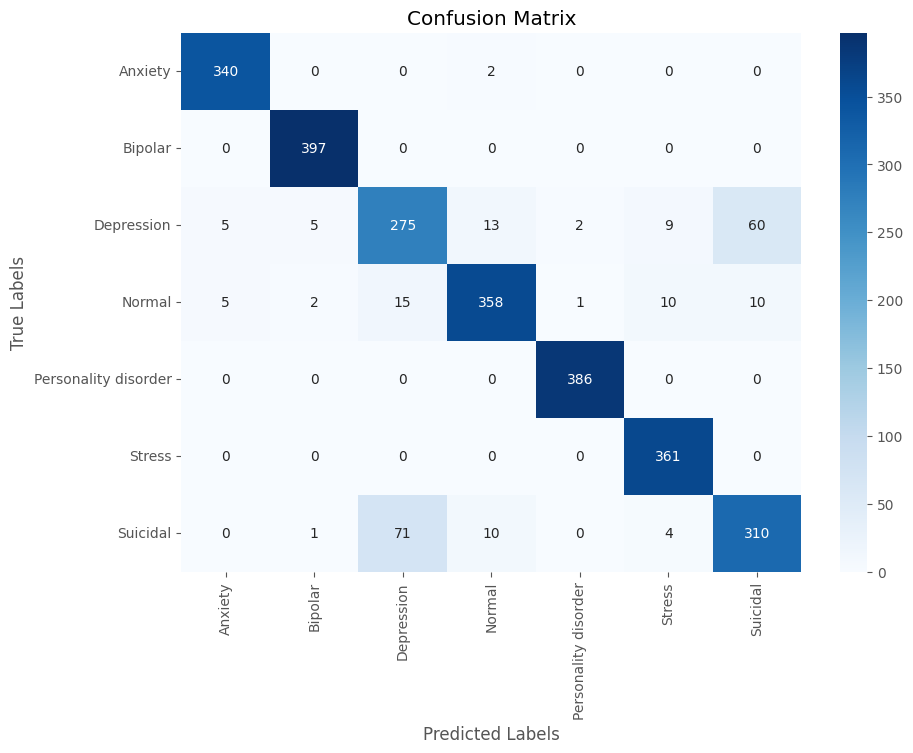

In [38]:
from sklearn.metrics import classification_report , confusion_matrix

#predections
predictions , labels , _ = trainer.predict(test_dataset)

#convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

#classification report
print(classification_report(y_test , predicted_labels , target_names = label_encoder.classes_))

#confusion matrix
cm = confusion_matrix(y_test , predicted_labels)
plt.figure(figsize= (10 , 7))
sns.heatmap(cm , annot= True , fmt= "d" , cmap= "Blues" , xticklabels= label_encoder.classes_ , yticklabels= label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show();

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Save & Load Model

In [41]:
trainer.save_model("/content/drive/MyDrive/saved_mental_status_bert")
tokenizer.save_pretrained("/content/drive/MyDrive/saved_mental_status_bert")

import pickle
pickle.dump(label_encoder , open("/content/drive/MyDrive/saved_mental_status_bert/label_encoder.pkl" , "wb"))

from transformers import AutoModelForSequenceClassification , AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/saved_mental_status_bert")

label_encoder = pickle.load(open("/content/drive/MyDrive/saved_mental_status_bert/label_encoder.pkl" , "rb"))

# Detection System

In [42]:

def classify_text(text):
    text = clean_statement(text)
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True , max_length = 200)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
    predicted_class = label_encoder.inverse_transform([predicted_label])[0]
    return predicted_class

In [45]:
text = "i feel perfectly fine today, nothing to worry about"
classify_text(text)

'Anxiety'